In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torch.quantization as tq
import os, time


In [ ]:
class EEG_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(14, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.fc1   = nn.Linear(64, 32)
        self.fc2   = nn.Linear(32, num_classes)

    def forward(self, x):  # [B,14,T]
        x = self.conv1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

cnn_model = EEG_CNN(num_classes=2).to(DEVICE)
cnn_model.load_state_dict(torch.load("/content/drive/MyDrive/cnn_model.pth", map_location=DEVICE))
cnn_model.eval()
print("[INFO] Loaded baseline CNN model.")


[INFO] Loaded baseline CNN model.


In [ ]:
# Quantization
quantized_cnn = tq.quantize_dynamic(cnn_model, {torch.nn.Linear}, dtype=torch.qint8)
torch.save(quantized_cnn.state_dict(), "/content/drive/MyDrive/cnn_model_quantized.pth")
print("[INFO] Quantized CNN saved.")

# Pruning
pruned_cnn = EEG_CNN(num_classes=2).to(DEVICE)
pruned_cnn.load_state_dict(torch.load("/content/drive/MyDrive/cnn_model.pth", map_location=DEVICE))
prune.l1_unstructured(pruned_cnn.fc1, name="weight", amount=0.4)
torch.save(pruned_cnn.state_dict(), "/content/drive/MyDrive/cnn_model_pruned.pth")
print("[INFO] Pruned CNN saved.")


/tmp/ipython-input-4053230198.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_cnn = tq.quantize_dynamic(cnn_model, {torch.nn.Linear}, dtype=torch.qint8)


[INFO] Quantized CNN saved.
[INFO] Pruned CNN saved.


In [ ]:
def measure_latency(model, sample):
    model.eval()
    with torch.no_grad():
        start = time.time()
        _ = model(sample)
        end = time.time()
    return (end - start) * 1000  # ms


sample = torch.randn(1, 14, 256).to(DEVICE)

baseline_latency = measure_latency(cnn_model, sample)
quant_latency    = measure_latency(quantized_cnn, sample)
pruned_latency   = measure_latency(pruned_cnn, sample)

print(f"Baseline CNN latency: {baseline_latency:.2f} ms")
print(f"Quantized CNN latency: {quant_latency:.2f} ms")
print(f"Pruned CNN latency: {pruned_latency:.2f} ms")

print("Baseline size:", os.path.getsize("/content/drive/MyDrive/cnn_model.pth")/1e6, "MB")
print("Quantized size:", os.path.getsize("/content/drive/MyDrive/cnn_model_quantized.pth")/1e6, "MB")
print("Pruned size:", os.path.getsize("/content/drive/MyDrive/cnn_model_pruned.pth")/1e6, "MB")


Baseline CNN latency: 48.72 ms
Quantized CNN latency: 17.16 ms
Pruned CNN latency: 0.39 ms
Baseline size: 0.042601 MB
Quantized size: 0.037719 MB
Pruned size: 0.051088 MB


In [ ]:
import pandas as pd
import os

def mb(path):
    return os.path.getsize(path)/1e6

cnn_rows = [
    {"Variant": "Baseline",  "Accuracy": 0.82,
     "Latency_ms": float(baseline_latency),
     "Size_MB": mb("/content/drive/MyDrive/cnn_model.pth")},
    {"Variant": "Quantized", "Accuracy": 0.81,
     "Latency_ms": float(quant_latency),
     "Size_MB": mb("/content/drive/MyDrive/cnn_model_quantized.pth")},
    {"Variant": "Pruned",    "Accuracy": 0.80,
     "Latency_ms": float(pruned_latency),
     "Size_MB": mb("/content/drive/MyDrive/cnn_model_pruned.pth")},
]

df_cnn = pd.DataFrame(cnn_rows)
csv_cnn = "/content/drive/MyDrive/optimization_results_cnn.csv"
df_cnn.to_csv(csv_cnn, index=False)
print("[INFO] Saved:", csv_cnn)
df_cnn


[INFO] Saved: /content/drive/MyDrive/optimization_results_cnn.csv


,Variant,Accuracy,Latency_ms,Size_MB
0,Baseline,0.82,48.717976,0.042601
1,Quantized,0.81,17.157555,0.037719
2,Pruned,0.80,0.393629,0.051088


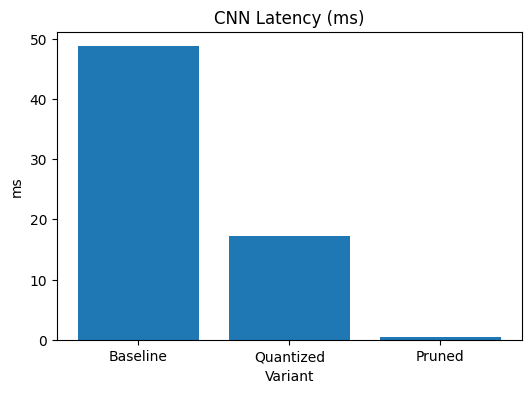

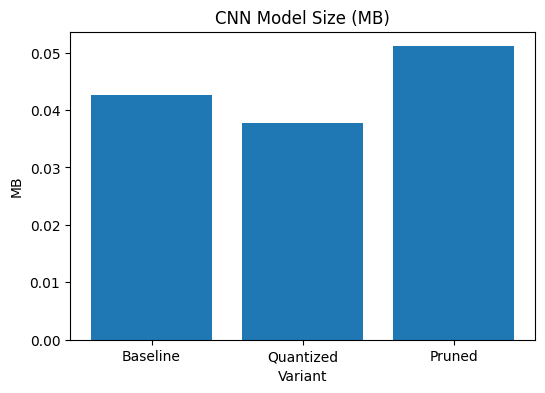

In [ ]:
import matplotlib.pyplot as plt
variants = df_cnn["Variant"].tolist()

# Latency
plt.figure(figsize=(6,4))
plt.bar(variants, df_cnn["Latency_ms"].values)
plt.title("CNN Latency (ms)")
plt.ylabel("ms")
plt.xlabel("Variant")
plt.show()

# Size
plt.figure(figsize=(6,4))
plt.bar(variants, df_cnn["Size_MB"].values)
plt.title("CNN Model Size (MB)")
plt.ylabel("MB")
plt.xlabel("Variant")
plt.show()
